In [22]:
pip install language_tool_python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
pip  install textstat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
pip install skll

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
# Import modules and setup notebook
%matplotlib inline
import sklearn
import numpy as np
import pandas as pd
import re

from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
plt.rcParams['figure.dpi']= 100

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from sklearn.decomposition import PCA
from sklearn import metrics
from numpy import mean
from numpy import absolute
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score,KFold
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score
from sklearn.model_selection import validation_curve
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import learning_curve
from sklearn import ensemble, metrics
from sklearn.metrics import mean_absolute_error
import joblib
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
# # kappa metric for measuring agreement of automatic to human scores
from skll.metrics import kappa


from yellowbrick.regressor import ResidualsPlot
plt.style.use('seaborn-colorblind')

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_colwidth', 100)

import warnings 
warnings.filterwarnings('ignore')

In [26]:
import numpy

def confusion_matrix(rater_a, rater_b,
    min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a)==len(rater_b))
    if min_rating is None:
        min_rating = min(reduce(min, rater_a), reduce(min, rater_b))
    if max_rating is None:
        max_rating = max(reduce(max, rater_a), reduce(max, rater_b))
    num_ratings = max_rating - min_rating + 1
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a,b in zip(rater_a,rater_b):
        conf_mat[a-min_rating][b-min_rating] += 1
    return conf_mat

def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None: min_rating = reduce(min, ratings)
    if max_rating is None: max_rating = reduce(max, ratings)
    num_ratings = max_rating - min_rating + 1
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r-min_rating] += 1
    return hist_ratings

def quadratic_weighted_kappa(rater_a, rater_b,
                             min_rating = None, max_rating = None):
    """
    Calculates the quadratic weighted kappa
    scoreQuadraticWeightedKappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1  
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    
    scoreQuadraticWeightedKappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
   
    score_quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(reduce(min, rater_a), reduce(min, rater_b))
    if max_rating is None:
        max_rating = max(reduce(max, rater_a), reduce(max, rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i]*hist_rater_b[j]
                    / num_scored_items) 
            d = pow(i-j,2.0) / pow(num_ratings-1, 2.0)
            numerator += d*conf_mat[i][j] / num_scored_items
            denominator += d*expected_count / num_scored_items

    return 1.0 - numerator / denominator

def linear_weighted_kappa(rater_a, rater_b,
                             min_rating = None, max_rating = None):
    """
    Calculates the linear weighted kappa
    linear_weighted_kappa calculates the linear weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1  
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    
    linear_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
   
    linear_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(reduce(min, rater_a), reduce(min, rater_b))
    if max_rating is None:
        max_rating = max(reduce(max, rater_a), reduce(max, rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i]*hist_rater_b[j]
                        / num_scored_items) 
            d = abs(i-j) / float(num_ratings-1)
            numerator += d*conf_mat[i][j] / num_scored_items
            denominator += d*expected_count / num_scored_items

    return 1.0 - numerator / denominator

def kappabh(rater_a, rater_b,
                             min_rating = None, max_rating = None):
    """
    Calculates the kappa
    kappa calculates the kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1  
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    
    kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
   
    kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(reduce(min, rater_a), reduce(min, rater_b))
    if max_rating is None:
        max_rating = max(reduce(max, rater_a), reduce(max, rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i]*hist_rater_b[j]
                        / num_scored_items) 
            if i==j:
                d=0.0
            else:
                d=1.0
            numerator += d*conf_mat[i][j] / num_scored_items
            denominator += d*expected_count / num_scored_items

    return 1.0 - numerator / denominator

def mean_quadratic_weighted_kappa(kappas, weights=None):
    """
    Calculates the mean of the quadratic
    weighted kappas after applying Fisher's r-to-z transform, which is
    approximately a variance-stabilizing transformation.  This
    transformation is undefined if one of the kappas is 1.0, so all kappa
    values are capped in the range (-0.999, 0.999).  The reverse
    transformation is then applied before returning the result.
    
    mean_quadratic_weighted_kappa(kappas), where kappas is a vector of
    kappa values
    mean_quadratic_weighted_kappa(kappas, weights), where weights is a vector
    of weights that is the same size as kappas.  Weights are applied in the
    z-space
    """
    kappas = numpy.array(kappas, dtype=float)
    if weights is None:
        weights = numpy.ones(numpy.shape(kappas))
    else:
        weights = weights / numpy.mean(weights)

    # ensure that kappas are in the range [-.999, .999]
    kappas = numpy.array([min(x, .999) for x in kappas])
    kappas = numpy.array([max(x, -.999) for x in kappas])
    
    z = 0.5 * numpy.log( (1+kappas)/(1-kappas) ) * weights
    z = numpy.mean(z)
    kappa = (numpy.exp(2*z)-1) / (numpy.exp(2*z)+1)
    return kappa

In [27]:
def evaluate(y_pred ,y_test):
  return kappa(y_pred, y_test, weights='quadratic')

In [28]:
def evaluate_model(model ,X_train ,X_test ,y_train ,y_test):
    train_y_pred = model.predict(X_train)
    test_y_pred = model.predict(X_test)
    train_mae = MAE(y_train, train_y_pred)
    train_mse = MSE(y_train, train_y_pred)
    train_rmse= np.sqrt(train_mse)
    train_r2 = r2_score(y_train,train_y_pred)
    test_mae = MAE(y_test, test_y_pred)
    test_mse = MSE(y_test, test_y_pred)
    test_rmse= np.sqrt(test_mse)
    test_r2 = r2_score(y_test,test_y_pred)
    
    report = f'----------\nTrain MAE : {train_mae} ,Train MSE : {train_mse} ,Train RMSE : {train_rmse},Train R2 : {train_r2}\nTest MAE : {test_mae} ,Test MSE : {test_mse} , Test RMSE : {test_rmse}, Test R2: {test_r2}\n----------'
    return report ,train_y_pred ,test_y_pred

In [29]:
training_set = pd.read_pickle('/content/drive/MyDrive/Final_all_Features.pkl')

In [30]:
df_all_features = [
                'word_count',
                'weights_uncommon',
                'unique_token_count',
                'nostop_count',
                'sent_count',
                'ner_count',
                'comma',
                'question',
                'exclamation',
                'quotation',
                'noun',
                'adj',
                'pron',
                'verb',
                'cconj',
                'adv',
                'num',
                'part',
                'intj',
               'pct_transitions',
               'grammar_chk',
               'determiners',
               'conjunctions',
               'prn_density',
               'prn_noun_ratio',
               'ncontent_tokens',
               'ncontent_types',
               'content_ttr',
               'nfunction_tokens',
               'function_ttr',
               'noun_ttr',
               'fre',
               'fkg',
               'cli',
               'ari',
               'dcrs', 
               'dw',
               'lwf',
               'gf',
               'avg_len_word',
               'avg_len_sent', 
               'num_chars',
               'sent_density',
               'ttr',
               'english_usage',
                'pct_rel_trigrams',
                # 'norm_score'
               ]

     

In [31]:
X = training_set [df_all_features]
y = training_set['norm_score'].astype(np.float64)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
stdscaler = StandardScaler()
X_train_scaled = stdscaler.fit_transform(X_train)
X_train_scaled.shape

(10380, 46)

In [34]:
X_train_scaled =  pd.DataFrame(X_train_scaled,columns=df_all_features,index=X_train.index)

In [35]:
X_test_scaled = stdscaler.transform(X_test)
X_test_scaled.shape

(2596, 46)

In [36]:
X_test_scaled=  pd.DataFrame(X_test_scaled,columns=df_all_features,index=X_test.index)

In [37]:
only_training_data = X_train.join(y_train)

In [ ]:
#How each feature affects the price of diamonds
correlations = only_training_data[df_all_features].corr()
correlations["norm_score"].sort_values(ascending=False)

norm_score            1.000000
dw                    0.433242
ncontent_types        0.380146
unique_token_count    0.374489
english_usage         0.366360
weights_uncommon      0.355758
noun                  0.345464
pct_rel_trigrams      0.344265
nostop_count          0.330469
ncontent_tokens       0.320763
num_chars             0.318271
adj                   0.314064
ner_count             0.313218
word_count            0.289080
avg_len_word          0.283566
comma                 0.281039
cli                   0.275511
sent_count            0.275097
pct_transitions       0.261715
adv                   0.251906
verb                  0.248134
nfunction_tokens      0.245112
cconj                 0.193762
quotation             0.190423
num                   0.164579
part                  0.163022
pron                  0.153199
dcrs                  0.098793
exclamation           0.095286
question              0.033941
ari                   0.021160
fkg                   0.014442
intj    

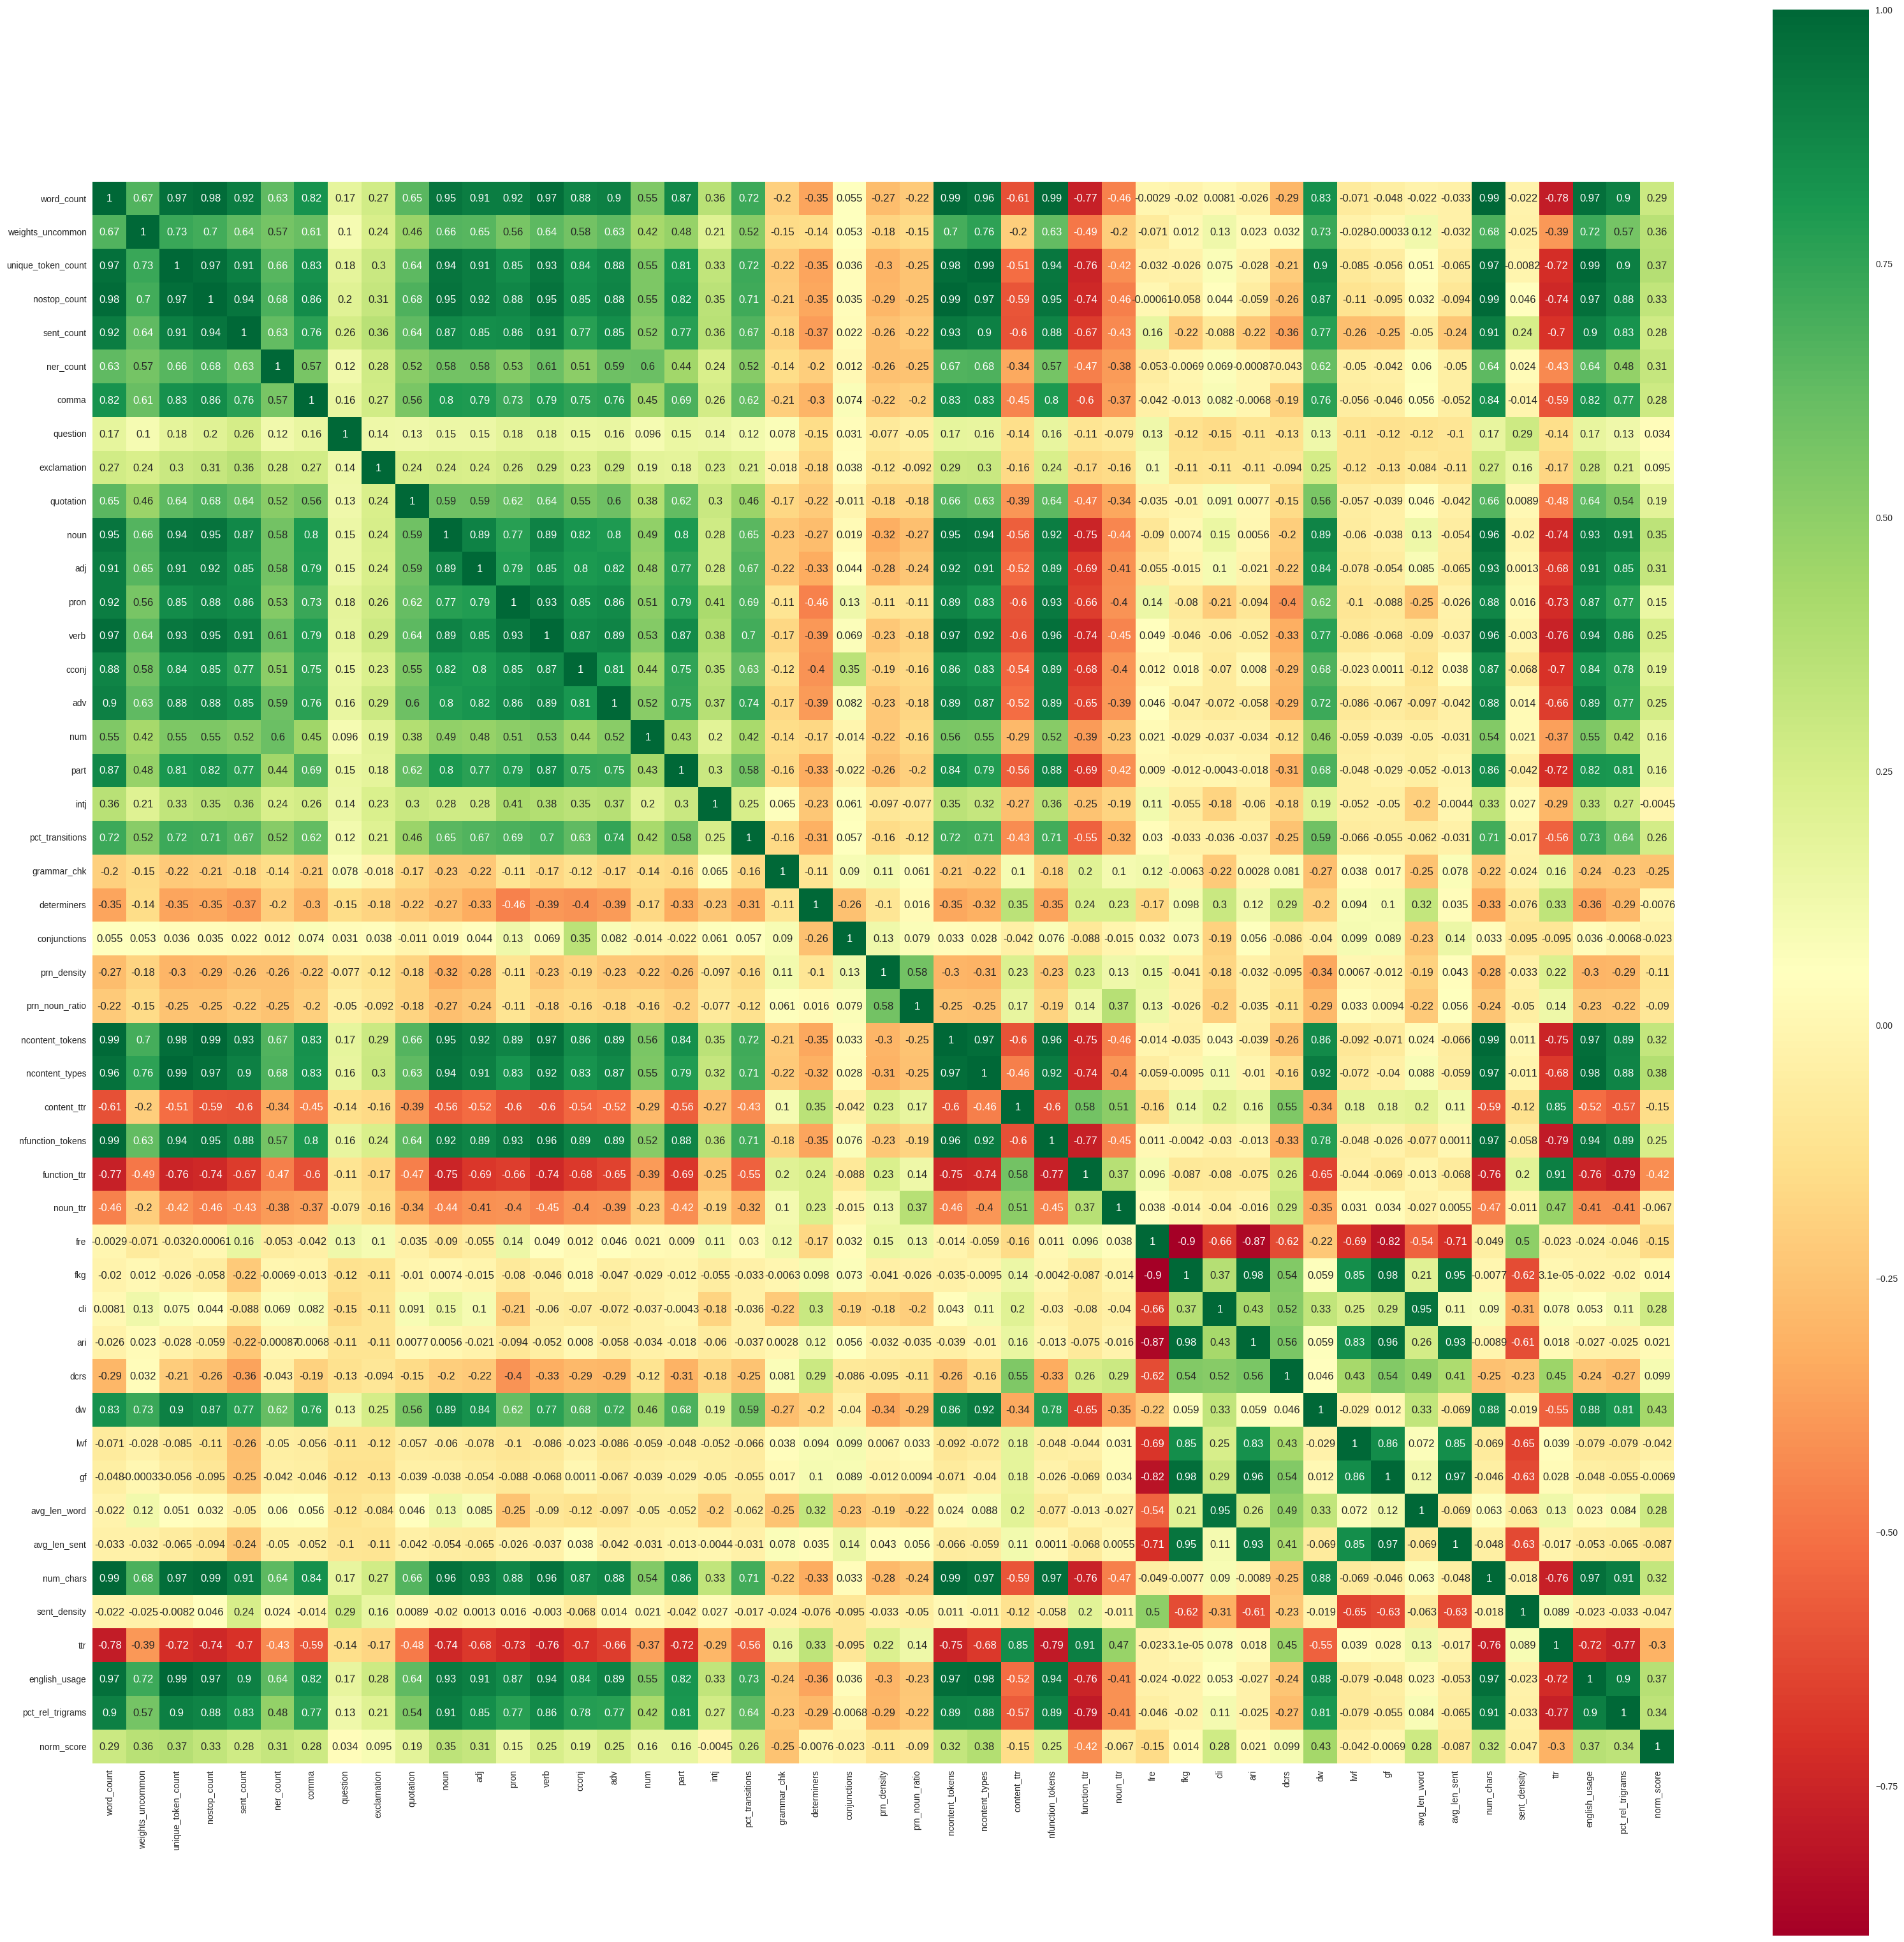

In [ ]:
plt.figure(figsize=(40,40))  # on this line I just set the size of figure to 30 by 30.
p=sns.heatmap(correlations, annot=True,cmap='RdYlGn',square=True)  # seaborn has very simple solution for heatmap

In [38]:
svr=SVR(kernel='rbf',C= 100, epsilon =0.7, gamma =0.004)

In [39]:
svr.fit(X_train_scaled, y_train)
y_pred=svr.predict(X_test_scaled)
print(evaluate_model(svr,X_train_scaled ,X_test_scaled ,y_train ,y_test)[0])

----------
Train MAE : 1.0709792813910561 ,Train MSE : 2.038813424517957 ,Train RMSE : 1.4278702407844899,Train R2 : 0.6280103862383621
Test MAE : 1.1311062295019079 ,Test MSE : 2.2772116933029234 , Test RMSE : 1.5090433039853175, Test R2: 0.5864874387913163
----------


In [40]:
kappas = []
weights = []

kappas.append(evaluate(y_pred, y_test))
weights.append(len(training_set))
mqwk = mean_quadratic_weighted_kappa(kappas,weights=weights)
print('Weighted by topic Kappa score: {:.4f}'.format(mqwk))
print('')

Weighted by topic Kappa score: 0.7328



In [41]:
# for use in pipeline
models = [
            [('scaler', StandardScaler()),('SVR', svr)]
        ]

In [42]:
models[0]

[('scaler', StandardScaler()), ('SVR', SVR(C=100, epsilon=0.7, gamma=0.004))]

In [ ]:
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(Pipeline(models[0]), X, y,scoring='r2', cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

K-fold CV average score: 0.57


In [ ]:
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(Pipeline(models[0]), X, y,scoring='neg_root_mean_squared_error', cv=kfold )
kf_cv_scores= -kf_cv_scores
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

K-fold CV average score: 1.52


In [ ]:
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(Pipeline(models[0]), X, y,scoring='neg_mean_absolute_error', cv=kfold )
kf_cv_scores= -kf_cv_scores
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

K-fold CV average score: 1.15


In [ ]:
i=0
for model in models:
  piplne = Pipeline(model)
  print(piplne)
  # evaluate model
  cv = KFold(n_splits=5, shuffle=True, random_state=1)
  train_size, train_score, valid_score = learning_curve(estimator=piplne,X=X, y=y, cv=cv,train_sizes=np.linspace(0.1, 1, 30),scoring = 'neg_mean_absolute_error',random_state=42)
  train_scores_mean = -train_score.mean(axis = 1)
  validation_scores_mean = -valid_score.mean(axis =1)
  print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_size))
  print('\n', '-' * 20) 
  print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_size))

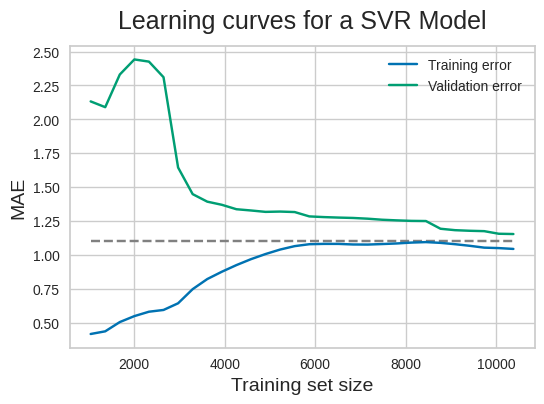

In [ ]:
plt.plot(train_size, train_scores_mean, label = 'Training error')
plt.plot(train_size, validation_scores_mean, label = 'Validation error')
plt.ylabel('MAE', fontsize = 14)
plt.hlines(np.mean([train_scores_mean[-1], validation_scores_mean[-1]]), train_size[0],train_size[-1],color='gray', linestyle='dashed')
plt.xlabel('Training set size', fontsize = 14)
title = 'Learning curves for a SVR Model'
plt.title(title, fontsize = 18, y = 1.03)
plt.legend(loc='best')
# plt.ylim(0,3)

In [ ]:
i=0
for model in models:
  piplne = Pipeline(model)
  print(piplne)
  # evaluate model
  cv = KFold(n_splits=5, shuffle=True, random_state=1)
  train_size, train_score, valid_score = learning_curve(estimator=piplne,X=X, y=y, cv=cv,train_sizes=np.linspace(0.1, 1, 30),scoring = 'neg_root_mean_squared_error',random_state=42)
  train_scores_mean = -train_score.mean(axis = 1)
  validation_scores_mean = -valid_score.mean(axis =1)
  print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_size))
  print('\n', '-' * 20) 
  print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_size))

Pipeline(steps=[('scaler', StandardScaler()),
                ('SVR', SVR(C=100, epsilon=0.3, gamma=0.003))])
Mean training scores

 1038     0.554251
1360     0.579030
1682     0.679499
2004     0.741474
2326     0.779908
2648     0.794120
2970     0.878664
3292     1.051577
3615     1.164068
3937     1.238077
4259     1.308664
4581     1.363496
4903     1.411646
5225     1.454781
5547     1.487328
5870     1.497241
6192     1.494736
6514     1.489005
6836     1.479069
7158     1.472949
7480     1.477764
7802     1.479139
8125     1.484450
8447     1.486714
8769     1.479618
9091     1.467855
9413     1.453946
9735     1.439208
10057    1.434755
10380    1.427161
dtype: float64

 --------------------

Mean validation scores

 1038     2.662151
1360     2.611042
1682     2.980089
2004     3.109851
2326     3.093601
2648     2.946806
2970     2.126287
3292     1.888745
3615     1.826550
3937     1.796990
4259     1.754315
4581     1.737145
4903     1.723722
5225     1.725136
5547     1.

(0.0, 4.0)

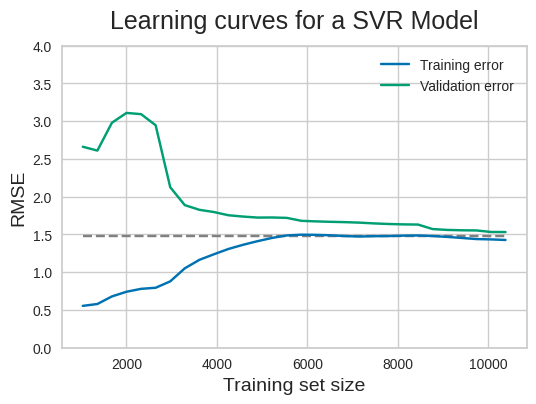

In [ ]:
plt.plot(train_size, train_scores_mean, label = 'Training error')
plt.plot(train_size, validation_scores_mean, label = 'Validation error')
plt.hlines(np.mean([train_scores_mean[-1], validation_scores_mean[-1]]), train_size[0],train_size[-1],color='gray', linestyle='dashed')
plt.ylabel('RMSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
title = 'Learning curves for a SVR Model'
plt.title(title, fontsize = 18, y = 1.03)
plt.legend(loc='best')
plt.ylim(0,4)

In [ ]:
for model in models:
  piplne = Pipeline(model)
  print(piplne)
  cv = KFold(n_splits=5, shuffle=True, random_state=1)
  train_size, train_score, valid_score = learning_curve(estimator=piplne,X=X, y=y, cv=cv,train_sizes=np.linspace(0.1, 1, 30),scoring ='r2',random_state=42)
  train_scores_mean = train_score.mean(axis =1)
  validation_scores_mean = valid_score.mean(axis =1)
  print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_size))
  print('\n', '-' * 20) 
  print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_size))

Pipeline(steps=[('scaler', StandardScaler()),
                ('SVR', SVR(C=100, epsilon=0.3, gamma=0.003))])
Mean training scores

 1038     0.872348
1360     0.857560
1682     0.834786
2004     0.817082
2326     0.800553
2648     0.795924
2970     0.760600
3292     0.698660
3615     0.661278
3937     0.642565
4259     0.624594
4581     0.624720
4903     0.628414
5225     0.623408
5547     0.629631
5870     0.630069
6192     0.632508
6514     0.634474
6836     0.640256
7158     0.642260
7480     0.641759
7802     0.643240
8125     0.643342
8447     0.642928
8769     0.642804
9091     0.641350
9413     0.641055
9735     0.641091
10057    0.634289
10380    0.628773
dtype: float64

 --------------------

Mean validation scores

 1038    -0.293008
1360    -0.245497
1682    -0.619042
2004    -0.764795
2326    -0.745923
2648    -0.583497
2970     0.173574
3292     0.349583
3615     0.391734
3937     0.411224
4259     0.438787
4581     0.449634
4903     0.458131
5225     0.457163
5547     0.

(-0.8, 1.0)

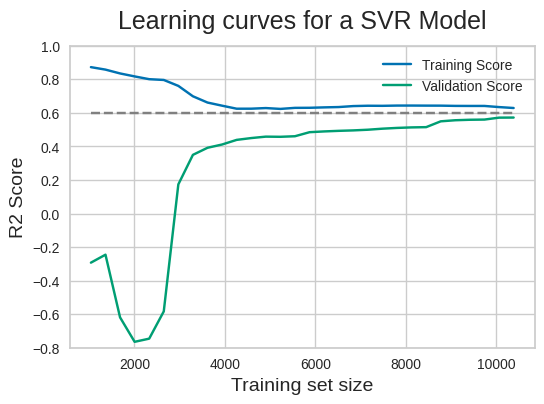

In [ ]:
plt.plot(train_size, train_scores_mean, label = 'Training Score')
plt.plot(train_size, validation_scores_mean, label = 'Validation Score')
plt.hlines(np.mean([train_score[-1], valid_score[-1]]), train_size[0],train_size[-1],color='gray', linestyle='dashed')
plt.ylabel('R2 Score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
title = 'Learning curves for a SVR Model'
plt.title(title, fontsize = 18, y = 1.03)
plt.legend(loc='best')
plt.ylim(-0.8,1)

In [43]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
import language_tool_python
from textstat.textstat import textstat
stop_words = set(STOP_WORDS)
stop_words.update(punctuation) # remove it if you need punctuation 
nlp = spacy.load('en_core_web_sm')


import sys, re, os, nltk
from nltk import word_tokenize
from nltk.corpus import words, wordnet
from nltk.tokenize import RegexpTokenizer, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
tokenizer = RegexpTokenizer(r'\w+')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
stopwords = nltk.corpus.stopwords.words('english')
wordset = set(words.words())
lmtzr = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [44]:
tool = language_tool_python.LanguageTool('en-US')

Unzipping /tmp/tmpzl0xg6bk.zip to /root/.cache/language_tool_python.
Downloaded https://www.languagetool.org/download/LanguageTool-5.7.zip to /root/.cache/language_tool_python.


In [45]:
def get_uncommon_words():

    uncommon_words= {}
    with open(r"uncommon-words-out.txt", 'r')as data_uncommon_file:
        for line in data_uncommon_file:
            uncommon_words[line.split()[0].lower()] = float(line.split()[1])
            #print(line.split()[0].lower())
    data_uncommon_file.close()
    return uncommon_words

In [46]:
def get_weights_uncommon_words(essay):
    weights_uncommon = get_uncommon_words()
    bag_of_words = []
    sentences = sent_tokenize(essay)
    for sentence in sentences:
        words = word_tokenize(sentence)
        for word in words:    
            if not word.lower() in stop_words and word.lower() in weights_uncommon:
                if not word.lower() in bag_of_words:
                    bag_of_words.append(word.lower())
    
    weights_sum = 0
    for word in bag_of_words:
        weights_sum += weights_uncommon[word.lower()]
    return weights_sum 

In [47]:
transition_words = [('and', 'then'), ('besides'), ('equally', 'important'), ('finally'), ('further'), 
('furthermore'), ('nor'), ('next'), ('lastly'), ('what\'s', 'more'), ('moreover'), ('in', 'addition'), 
('first'), ('second'), ('third'), ('fourth'), ('whereas'), ('yet'), ('on', 'the', 'other', 'hand'), ('however'), 
('nevertheless'), ('on', 'the', 'contrary'), ('by', 'comparison'), ('compared', 'to'), ('up', 'against'), 
('balanced', 'against'), ('vis', 'a', 'vis'), ('although'), ('conversely'), ('meanwhile'), ('after', 'all'), 
('in', 'contrast'), ('although', 'this', 'may', 'be', 'true'), ('because'), ('since'), ('for', 'the', 'same', 'reason'), 
('obviously'), ('evidently'), ('indeed'), ('in', 'fact'), ('in', 'any', 'case'), ('that', 'is'), ('still'), ('in', 'spite', 'of'), 
('despite'), ('of', 'course'), ('once', 'in', 'a', 'while'), ('sometimes'), ('immediately'), ('thereafter'), ('soon'), 
('after', 'a', 'few', 'hours'), ('then'), ('later'), ('previously'), ('formerly'), ('in', 'brief'), ('as', 'I', 'have', 'said'), 
('as', 'I', 'have', 'noted'), ('as', 'has', 'been', 'noted'), ('definitely'), ('extremely'), ('obviously'), ('absolutely'), 
('positively'), ('naturally'), ('surprisingly'), ('always'), ('forever'), ('perennially'), ('eternally'), ('never'), 
('emphatically'), ('unquestionably'), ('without', 'a', 'doubt'), ('certainly'), ('undeniably'), ('without', 'reservation'), 
('following', 'this'), ('at', 'this', 'time'), ('now'), ('at', 'this', 'point'), ('afterward'), ('subsequently'), ('consequently'), 
('previously'), ('before', 'this'), ('simultaneously'), ('concurrently'), ('thus'), ('therefore'), ('hence'), ('for', 'example'), 
('for', 'instance'), ('in', 'this', 'case'), ('in', 'another', 'case'), ('on', 'this', 'occasion'), ('in', 'this', 'situation'), 
('take', 'the', 'case', 'of'), ('to', 'demonstrate'), ('to', 'illustrate'), ('as', 'an', 'illustration'), ('on', 'the', 'whole'), 
('summing', 'up'), ('to', 'conclude'), ('in', 'conclusion'), ('as', 'I', 'have', 'shown'), ('as', 'I', 'have', 'said'), 
('accordingly'), ('as', 'a', 'result')]

In [48]:
transitions_set = set(transition_words)

In [49]:
relevant_trigrams = [('IN', 'DT', 'NN'), ('VB', 'JJ', 'NNS'), ('VBZ', 'JJ', 'NNS'), ('PRP', 'TO', 'VB'), 
('VB', 'DT', 'NN'), ('DT', 'JJ', 'NNS'), ('CC', 'JJ', 'NN'), ('CC', 'PRP', 'VBZ'), ('.', 'NN', 'VBP'), 
('TO', 'VB', 'IN'), ('DT', 'NN', 'VBP'), ('DT', 'NNS', 'VBP'), ('PRP$', 'NN', 'CC'), ('NN', '.', 'WRB'), 
('JJ', 'NN', 'CC'), ('VBP', 'RB', 'JJ'), ('TO', 'VB', 'JJR'), ('VB', 'NN', 'IN'), ('VBN', 'TO', 'VB'), 
('JJ', 'IN', 'PRP'), ('NNS', '.', 'IN'), ('PRP', 'VBP', 'JJ'), ('IN', 'NN', '.'), ('RB', ',', 'NN'), 
(',', 'DT', 'NNS'), ('NN', 'CC', 'TO'), ('NNS', 'RB', 'VBP'), ('JJ', 'NNS', ','), ('NN', '.', 'IN'), 
(',', 'IN', 'NNS'), ('NN', 'IN', 'NNS'), ('VBZ', 'DT', 'JJ'), ('JJ', 'VBP', 'RB'), ('VBP', 'DT', 'NN'), 
(',', 'PRP', 'RB'), ('JJ', 'NN', 'IN'), ('NNS', 'VBP', 'JJ'), ('VBZ', 'DT', 'NN'), ('MD', 'VB', 'PRP'), 
('DT', 'NNS', '.'), ('IN', 'PRP', 'VBZ'), ('NN', 'TO', 'VB'), ('VBZ', 'VBN', 'TO'), ('NN', '.', 'NNS'), 
('PRP', 'MD', 'VB'), ('PRP', 'VBD', 'DT'), ('IN', 'PRP', 'TO'), ('VB', 'IN', 'IN'), (',', 'IN', 'PRP'), 
('RB', 'VB', 'NNS'), ('VBP', 'RB', 'VB'), ('RB', 'VB', 'NN'), ('.', 'DT', 'NN'), ('DT', 'NN', 'VBZ'), 
('NN', 'IN', 'DT'), ('VBP', 'DT', 'JJ'), ('VBG', 'JJ', 'TO'), ('NNS', 'VBP', 'NN'), ('NNS', ',', 'NN'), 
('NNS', 'IN', 'NN'), ('NN', 'IN', 'NN'), ('VBP', 'JJR', 'NN'), ('VBD', 'TO', 'VB'), ('VB', 'JJ', 'VBZ'), 
('JJR', 'NN', 'CC'), ('NNS', '.', 'RB'), ('NNS', 'WDT', 'VBP'), ('VBG', 'PRP', 'TO'), ('NN', ',', 'JJ'), 
('VBP', 'JJ', 'NN'), ('NN', ',', 'CD'), ('IN', 'PRP', 'RB'), ('MD', 'VB', 'TO'), (',', 'PRP', 'MD'), 
('IN', 'CD', 'NNS'), (',', 'NN', 'VBP'), ('DT', 'NN', 'IN'), ('PRP', 'VBD', 'IN'), ('JJ', 'NN', 'MD'), 
('NN', 'IN', 'PRP$'), ('TO', 'NNS', 'MD'), ('NN', '.', 'DT'), ('NNS', 'JJ', 'IN'), ('NNS', 'IN', 'DT'), 
('.', 'DT', 'JJ'), ('PRP', 'NNS', ','), ('NNS', ',', 'EX'), ('IN', 'NN', ','), ('NN', 'MD', 'VB'), 
('PRP', 'RB', '.'), ('NNS', 'MD', 'VB'), ('JJ', '.', 'RB'), (',', 'PRP', 'VBD'), ('NNS', 'TO', 'VB'), 
('NN', 'VBZ', 'PRP'), ('NNS', 'IN', 'PRP'), ('VBD', 'DT', 'JJ'), ('WP', 'MD', 'VB'), ('IN', 'VBG', 'CC'), 
('IN', 'NN', 'IN'), ('JJ', ',', 'VBG'), ('MD', 'VB', 'NNS'), ('CC', 'WRB', 'PRP'), ('DT', 'NNS', 'IN'), 
('WRB', 'PRP', 'VBP'), ('DT', 'NNS', 'VBD'), ('RB', 'VB', 'IN'), ('NN', 'DT', 'NN'), ('DT', 'NN', '.'), 
('CC', 'VBG', 'IN'), ('VBP', 'JJR', 'NNS'), ('.', 'IN', 'IN'), ('IN', 'PRP$', 'NN'), ('VB', 'PRP$', 'NN'), 
('.', 'DT', 'MD'), ('RB', ',', 'PRP'), ('IN', 'DT', 'JJ'), ('.', 'IN', 'NN'), (',', 'PRP', 'VBP')]

In [50]:
relevant_trigram_set = set(relevant_trigrams)

In [51]:
def get_features_1(text):
  sents = []
  tokens = []
  lemma = []
  pos = []
  ner = []
  
  input_df= pd.DataFrame (text, columns = ['essay'])
  input_df['matches'] = input_df['essay'].apply(lambda essay: tool.check(essay))
  input_df['corrections_len'] =input_df.apply(lambda l: len(l['matches']), axis=1)
  input_df['corrected'] = input_df.apply(lambda l: tool.correct(l['essay']), axis=1)
  for essay in nlp.pipe(input_df['corrected'], batch_size=100, n_process=3):
    if essay.is_parsed:
      tokens.append([e.text for e in essay])
      sents.append([sent.text.strip() for sent in essay.sents])
      pos.append([e.pos_ for e in essay])
      ner.append([e.text for e in essay.ents])
      lemma.append([n.lemma_ for n in essay])
      
  input_df['tokens'] = tokens
  input_df['lemma'] = lemma
  input_df['pos'] = pos
  input_df['sents'] = sents
  input_df['ner'] = ner
  
  input_df['word_count'] = input_df['essay'].str.strip().str.split().str.len()
  input_df['token_count'] = input_df.apply(lambda x: len(x['tokens']), axis=1)
  input_df['unique_token_count'] = input_df.apply(lambda x: len(set(x['tokens'])), axis=1)
  input_df['nostop_count'] = input_df.apply(lambda x: len([token for token in x['tokens'] if token not in stop_words]), axis=1)
  input_df['sent_count'] = input_df.apply(lambda x: len(x['sents']), axis=1)
  input_df['ner_count'] = input_df.apply(lambda x: len(x['ner']), axis=1)
  input_df['comma'] = input_df.apply(lambda x: x['corrected'].count(','), axis=1)
  input_df['question'] = input_df.apply(lambda x: x['corrected'].count('?'), axis=1)
  input_df['exclamation'] = input_df.apply(lambda x: x['corrected'].count('!'), axis=1)
  input_df['quotation'] = input_df.apply(lambda x: x['corrected'].count('"') + x['corrected'].count("'"), axis=1)
  input_df['noun'] = input_df.apply(lambda x: x['pos'].count('NOUN'), axis=1)
  input_df['adj'] = input_df.apply(lambda x: x['pos'].count('ADJ'), axis=1)
  input_df['pron'] = input_df.apply(lambda x: x['pos'].count('PRON'), axis=1)
  input_df['verb'] = input_df.apply(lambda x: x['pos'].count('VERB'), axis=1)
  input_df['cconj'] = input_df.apply(lambda x: x['pos'].count('CCONJ'), axis=1)
  input_df['adv'] = input_df.apply(lambda x: x['pos'].count('ADV'), axis=1)
  input_df['det'] = input_df.apply(lambda x: x['pos'].count('DET'), axis=1)#
  input_df['propn'] = input_df.apply(lambda x: x['pos'].count('PROPN'), axis=1)
  input_df['num'] = input_df.apply(lambda x: x['pos'].count('NUM'), axis=1)
  input_df['part'] = input_df.apply(lambda x: x['pos'].count('PART'), axis=1)#
  input_df['intj'] = input_df.apply(lambda x: x['pos'].count('INTJ'), axis=1)#
  input_df['weights_uncommon']=input_df.apply(lambda x: get_weights_uncommon_words(x['corrected']), axis=1)
  return input_df

In [52]:
def get_features_2(essay):
  input_df= pd.DataFrame (essay, columns = ['essay'])
  output_list = []
  for index, row in input_df.iterrows():
    essay = row['essay']
    # With punctuation, not lowered
    tokens = word_tokenize(essay)
    tagged = nltk.pos_tag(tokens)
    num_sents = len(sent_tokenize(essay))
    
    # With punctuation, lowered
    essay_low = essay.strip().lower()
    tokens_low = word_tokenize(essay_low)
    tagged_low = nltk.pos_tag(tokens_low)
    
    # Without punctuation, not lowered
    tokens_np = tokenizer.tokenize(essay)
    num_tokens = len(tokens_np)
    
    # Without punctuation, lowered
    tokens_low_np = tokenizer.tokenize(essay_low)
    types = set(tokens_low_np)
    num_types = len(types)
    
    # Content and function words
    content_tokens = [w for w in tokens_np if w not in stopwords]
    content_types = [w for w in types if w not in stopwords]
    
    function_tokens = [w for w in tokens_np if w in stopwords]
    function_types = [w for w in types if w in stopwords]
    
    
    # Length feature extractor
    len_words = []
    for word in tokens_np:
        len_words.append(len(word))
        avg_len_word = round(sum(len_words) / num_tokens, 4)
    
    # Sentence density feature extractor
    sent_density = round(num_sents / num_tokens * 100, 2)
    
    # Lexical diversity feature extractor
    ttr = round(num_types / num_tokens * 100, 2)
    
    # English words feature extractor
    english_types = []
    for word in types:
        if word in wordset:
            english_types.append(word)
    english_usage = len(english_types)
    
    # Percent of relevant trigrams in essay
    a, b = zip(*tagged)
    trigram_set = set(nltk.trigrams(b))
    found_trigrams = relevant_trigram_set & trigram_set
    pct_rel_trigrams = round(len(found_trigrams) / len(relevant_trigram_set) * 100, 2)
    
    found_transitions = transitions_set & types
    pct_transitions = round(len(found_transitions) / len(transitions_set), 4)
    
    for word in found_transitions:
        transition_word = word
    
    matches = tool.check(essay)
    grammar_chk = round(len(matches)/len(tokens_np), 5)
    
    rules =[]
    for match in matches:
        match_list = list(match)
        match_rule = match_list[4]
        rules.append(match_rule)
    for rule in set(rules):
        grammar_error = rule
    
    
    # content_words
    ncontent_tokens = len(content_tokens)
    ncontent_types = len(content_types)
    
    try:
        content_ttr = round(ncontent_types/ncontent_tokens,4)
    except ZeroDivisionError:
        content_ttr = 1
    
    # function_words
    nfunction_tokens = len(function_tokens)
    nfunction_types = len(function_types)
    
    try:
        function_ttr = round(nfunction_types/nfunction_tokens,4)
    except ZeroDivisionError:
        function_ttr = 1
        
    # noun_ttr
    nouns = []
    for word, tag in tagged:
        if re.search(r'\b(NN(S|P|PS))\b', tag):
            nouns.append(word)
    try:
        noun_ttr = round(len(set(nouns))/len(nouns),4)
    except ZeroDivisionError:
        noun_ttr = 0
        
    # determiners
    det = len(re.findall(r'\b(DT)\b', str(tagged), flags=re.I))
    determiners = round(det/len(tokens_np), 5)
        
    # conjunctions
    conj = len(re.findall(r'\b(and|but)\W+(CC)\b', str(tagged), flags=re.I))
    conjunctions = round(conj/len(tokens_np), 5)
    # pronouns
    prn = len(re.findall(r'\b(he|she|it|his|hers|him|her|they|them|their)\b', str(tokens), flags=re.I))
    prn_density = round(prn/len(tokens_np), 5)
    try:
        prn_noun_ratio = round(prn/len(nouns), 2)
    except ZeroDivisionError:
        prn_noun_ratio = 0
    ## Readability features
    avg_len_sent = textstat.avg_sentence_length(essay)
    num_chars = textstat.char_count(essay, ignore_spaces=True)
    fre = textstat.flesch_reading_ease(essay)
    fkg = textstat.flesch_kincaid_grade(essay)
    cli = textstat.coleman_liau_index(essay)
    ari = textstat.automated_readability_index(essay)
    dcrs = textstat.dale_chall_readability_score(essay)
    dw = textstat.difficult_words(essay)
    lwf = textstat.linsear_write_formula(essay)
    gf = textstat.gunning_fog(essay)
    output_list.append([pct_transitions, grammar_chk, determiners, conjunctions, prn_density, prn_noun_ratio, ncontent_tokens, ncontent_types,content_ttr, nfunction_tokens, function_ttr, noun_ttr, fre, fkg, cli, ari, dcrs, dw, lwf, gf,avg_len_word, avg_len_sent, num_chars, sent_density,ttr, english_usage, pct_rel_trigrams])
    df = pd.DataFrame (output_list, columns = ['pct_transitions', 'grammar_chk', 'determiners', 'conjunctions', 'prn_density', 'prn_noun_ratio','ncontent_tokens', 'ncontent_types', 'content_ttr', 'nfunction_tokens', 'function_ttr', 'noun_ttr', 'fre', 'fkg', 'cli', 'ari', 'dcrs', 'dw', 'lwf', 'gf','avg_len_word', 'avg_len_sent','num_chars', 'sent_density', 'ttr', 'english_usage', 'pct_rel_trigrams'])
    return df

       
     

In [109]:
with open('sample_essays.txt') as f:
  text = f.readlines()

In [110]:
print(text)

["It was dangerous, but I knew I had to do it .I knew, I would not come  this world again, everyone has only one change to do whatever they want.I come from  very ruler family. You had never made on your , you always had to ask your family's opinion.I had always wanted to be a theatre actress. I was saving my pocket money to go to the theatre  age  15. During the this years I had met with Zuhal Olcoy. I had seen her every morning while I was going to school. Despite of  going to school by bus  easier than riding  bycyle I had prefered to going to school by bycyle to  by bus. In that way I had been able to see her every morning. The more seeing her I could, the more ambitious I became. At last I met wit her. She had invited me  her play to the theatre. When I went to her play to see, I  realy would love to be a actress. She was the only person who encourage me to be a actress.I had had a exam for  being theatre players without saying my family. Otherwise my father could kill me and not 

In [111]:
df1= get_features_1(text)
df2=get_features_2(text)

In [112]:
df1.head()

,essay,matches,corrections_len,corrected,tokens,lemma,pos,sents,ner,word_count,token_count,unique_token_count,nostop_count,sent_count,ner_count,comma,question,exclamation,quotation,noun,adj,pron,verb,cconj,adv,det,propn,num,part,intj,weights_uncommon
0,"It was dangerous, but I knew I had to do it .I knew, I would not come this world again, everyon...","[Offset 43, length 2, Rule ID: COMMA_PARENTHESIS_WHITESPACE\nMessage: Don’t put a space before t...",41,"It was dangerous, but I knew I had to do it. I knew, I would not come this world again, everyone...","[It, was, dangerous, ,, but, I, knew, I, had, to, do, it, ., I, knew, ,, I, would, not, come, th...","[it, be, dangerous, ,, but, I, know, I, have, to, do, it, ., I, know, ,, I, would, not, come, th...","[PRON, AUX, ADJ, PUNCT, CCONJ, PRON, VERB, PRON, VERB, PART, VERB, PRON, PUNCT, PRON, VERB, PUNC...","[It was dangerous, but I knew I had to do it., I knew, I would not come this world again, everyo...","[only one, age 15, Rural McCoy]",243,272,122,115,21,3,9,0,0,1,42,7,53,40,2,14,15,2,2,12,0,0.000064


In [113]:
df2.head()

,pct_transitions,grammar_chk,determiners,conjunctions,prn_density,prn_noun_ratio,ncontent_tokens,ncontent_types,content_ttr,nfunction_tokens,function_ttr,noun_ttr,fre,fkg,cli,ari,dcrs,dw,lwf,gf,avg_len_word,avg_len_sent,num_chars,sent_density,ttr,english_usage,pct_rel_trigrams
0,0.0374,0.16599,0.07287,0.0081,0.04858,3.0,139,73,0.5252,108,0.4074,1.0,85.18,4.2,3.52,2.7,5.9,23,5.0,5.92,3.7085,11.5,944,6.48,47.37,102,21.85


In [114]:
df = pd.concat([df1,df2], axis=1)
df.shape

(1, 58)

In [115]:
df.head()

,essay,matches,corrections_len,corrected,tokens,lemma,pos,sents,ner,word_count,token_count,unique_token_count,nostop_count,sent_count,ner_count,comma,question,exclamation,quotation,noun,adj,pron,verb,cconj,adv,det,propn,num,part,intj,weights_uncommon,pct_transitions,grammar_chk,determiners,conjunctions,prn_density,prn_noun_ratio,ncontent_tokens,ncontent_types,content_ttr,nfunction_tokens,function_ttr,noun_ttr,fre,fkg,cli,ari,dcrs,dw,lwf,gf,avg_len_word,avg_len_sent,num_chars,sent_density,ttr,english_usage,pct_rel_trigrams
0,"It was dangerous, but I knew I had to do it .I knew, I would not come this world again, everyon...","[Offset 43, length 2, Rule ID: COMMA_PARENTHESIS_WHITESPACE\nMessage: Don’t put a space before t...",41,"It was dangerous, but I knew I had to do it. I knew, I would not come this world again, everyone...","[It, was, dangerous, ,, but, I, knew, I, had, to, do, it, ., I, knew, ,, I, would, not, come, th...","[it, be, dangerous, ,, but, I, know, I, have, to, do, it, ., I, know, ,, I, would, not, come, th...","[PRON, AUX, ADJ, PUNCT, CCONJ, PRON, VERB, PRON, VERB, PART, VERB, PRON, PUNCT, PRON, VERB, PUNC...","[It was dangerous, but I knew I had to do it., I knew, I would not come this world again, everyo...","[only one, age 15, Rural McCoy]",243,272,122,115,21,3,9,0,0,1,42,7,53,40,2,14,15,2,2,12,0,0.000064,0.0374,0.16599,0.07287,0.0081,0.04858,3.0,139,73,0.5252,108,0.4074,1.0,85.18,4.2,3.52,2.7,5.9,23,5.0,5.92,3.7085,11.5,944,6.48,47.37,102,21.85


In [116]:
X_input=df[df_all_features]

In [117]:
X_input_scaled =stdscaler.transform(X_input)

In [118]:
y_pred_input=svr.predict(X_input_scaled)

In [119]:
print(y_pred_input)

[6.17533508]
